In [1]:
import requests
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
import matplotlib.pyplot as plt

In [2]:
def es_into_df(es_outcome: list):
    data = []
    for document in es_outcome:
        if '_source' in document:
            data.append(document['_source'])
    df = pd.DataFrame(data)
    return df

def fetch_data(body, index_name):
    client = Elasticsearch(
        'https://localhost:9200',
        basic_auth=("elastic", "elastic"),
        verify_certs=False,
        ssl_show_warn=False
    )

    response = client.search(body=body, index=index_name)
    return es_into_df(response['hits']['hits'])

def fetch_all_data(index_name):
    client = Elasticsearch(
        'https://localhost:9200',
        basic_auth=("elastic", "elastic"),
        verify_certs=False,
        ssl_show_warn=False
    )
    results = scan(client, index=index_name, query={"query": {"match_all": {}}})
    document= [doc for doc in results]
    return es_into_df(document)

In [3]:
'''query = {"size": 10000, "query": {"match_all": {}}}
index = 'pollen'
pollen = fetch_data(query,index_name=index)
print(pollen)'''

'query = {"size": 10000, "query": {"match_all": {}}}\nindex = \'pollen\'\npollen = fetch_data(query,index_name=index)\nprint(pollen)'

## 天气数据

In [39]:
# 设置连接到 Elasticsearch 的参数
es = Elasticsearch(
    ['https://127.0.0.1:9200'],
    basic_auth=('elastic', 'elastic'),
    verify_certs=False
)

# 使用 search 方法进行查询，获取前 100 个文档
response = scan(es, index='bom-000001', query={"query":{"match_all": {}}})

# 初始化一个空列表来存储结果
bomdata = []

# 迭代 response 中的 hits，将每个 hit 的 '_source' 加入到列表中
for hit in response:
    bomdata.append(hit['_source'])

# 将列表转换成 DataFrame
bomData = pd.DataFrame(bomdata)
# 打印 DataFrame 的前五行
print(bomData.head())

                       name local_date_time_full  latitude  longitude  \
0  Melbourne (Olympic Park)  2024-05-10-19-30-00     -37.8      145.0   
1  Melbourne (Olympic Park)  2024-05-10-21-30-00     -37.8      145.0   
2  Melbourne (Olympic Park)  2024-05-10-21-00-00     -37.8      145.0   
3  Melbourne (Olympic Park)  2024-05-10-19-00-00     -37.8      145.0   
4  Melbourne (Olympic Park)  2024-05-10-20-30-00     -37.8      145.0   

   air_temp  apparent_t  delta_t  dewpt  gust_kmh   press  rain_trace  \
0      14.8        16.0      0.0   14.8       9.0  1028.4         0.6   
1      14.4        15.8      0.0   14.4       0.0  1028.6         0.6   
2      14.4        15.8      0.0   14.4       4.0  1028.4         0.6   
3      14.7        15.8      0.0   14.7       6.0  1028.4         0.6   
4      14.5        15.2      0.0   14.5       9.0  1028.4         0.6   

   rel_hum  vis_km wind_dir  wind_spd_kmh  wind_spd_kt    wmo  lat  lon  
0      100    10.0        S           2.0       

In [40]:
print(bomData.name.unique())

['Melbourne (Olympic Park)' 'Canberra' 'Campbelltown' 'Brisbane']


In [41]:
replacements = {
    'Melbourne (Olympic Park)': 'Melbourne',
}

# 使用replace方法进行替换
bomData['name'] = bomData['name'] .replace(replacements)


##### 降雨分布直方图

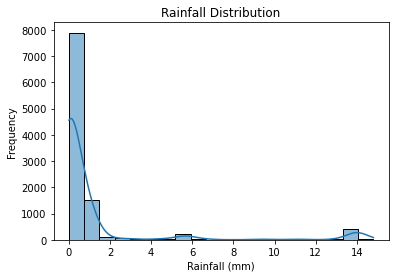

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# 如果列名无误，则绘制直方图
sns.histplot(bomData['rain_trace'], bins=20, kde=True)
plt.title('Rainfall Distribution')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Frequency')
plt.show()


 ##### 风向和风速的极坐标图

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 假设数据已经正确加载到bomData DataFrame中，并且'wind_dir'列已经包含方向的字符串描述
wind_direction_map = {
    'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
    'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
    'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
    'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5,
    'CALM': 0  # 假设 CALM 代表没有风
}

# 替换并转换数据
bomData['wind_dir'] = bomData['wind_dir'].replace(wind_direction_map)
bomData['wind_dir'] = bomData['wind_dir'].astype(float)

# 处理风速数据，假设已经在DataFrame中
bomData['wind_spd_kmh']

0         2.0
1         0.0
2         0.0
3         2.0
4         4.0
         ... 
10351     9.0
10352     7.0
10353    19.0
10354    11.0
10355    15.0
Name: wind_spd_kmh, Length: 10356, dtype: float64

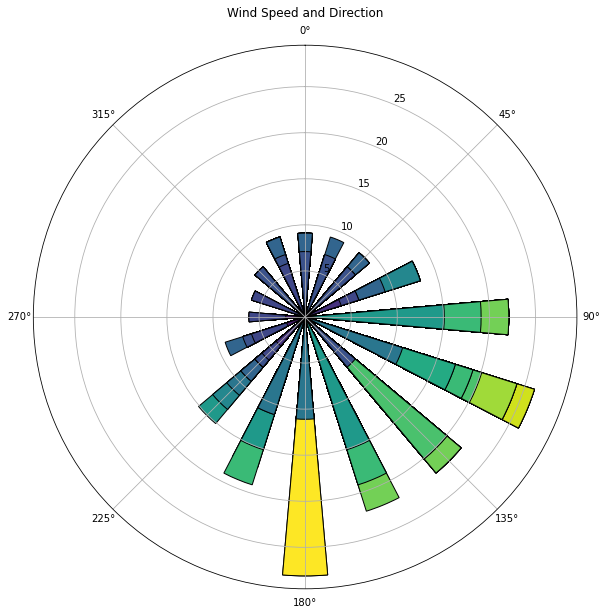

In [ ]:
# 创建极坐标图
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

# 颜色映射：根据风速变化颜色
colors = plt.cm.viridis((bomData['wind_spd_kmh'] - bomData['wind_spd_kmh'].min()) / (bomData['wind_spd_kmh'].max() - bomData['wind_spd_kmh'].min()))

# 绘制条形图
bars = ax.bar(np.deg2rad(bomData['wind_dir']), bomData['wind_spd_kmh'], width=np.deg2rad(10), color=colors, edgecolor='black', bottom=0.1)

# 设置图表标题和参数
ax.set_theta_zero_location('N')  # 设置图表的0度（正北）
ax.set_theta_direction(-1)       # 设置方向顺时针
ax.set_title('Wind Speed and Direction', va='bottom')

# 调整网格线和标签
ax.grid(True)

plt.show()

## 花粉数据

In [ ]:
# 设置连接到 Elasticsearch 的参数
es = Elasticsearch(
    ['https://127.0.0.1:9200'],
    basic_auth=('elastic', 'elastic'),
    verify_certs=False
)

# 使用 search 方法进行查询，获取前 100 个文档
response = scan(es, index='pollen', query={"query":{"match_all": {}}})

# 初始化一个空列表来存储结果
pollen = []

# 迭代 response 中的 hits，将每个 hit 的 '_source' 加入到列表中
for hit in response:
    pollen.append(hit['_source'])

# 将列表转换成 DataFrame
pollen = pd.DataFrame(pollen)
pollen

,id,area,poaceae_pollen,other_pollen,longitude,latitude,start_date,end_date
0,rocklea_qld_6168c420545c70ad5962f414.fid--2d76...,rocklea,0.0,0.0,152.993300,-27.535100,2016-07-01,2016-07-08
1,canberra_act_6168c4209b7c5111055ffa84.fid-4d8c...,canberra,0.0,0.0,149.116667,-35.266667,2016-07-01,2016-07-08
2,parkville_vic_6168c42016eb4e98d9b8cb28.fid-416...,parkville,0.0,0.0,144.964900,-37.797100,2016-07-01,2016-07-08
3,rocklea_qld_6168c420545c70ad5962f414.fid--2d76...,rocklea,0.0,0.0,152.993300,-27.535100,2016-07-08,2016-07-15
4,canberra_act_6168c4209b7c5111055ffa84.fid-4d8c...,canberra,0.0,0.0,149.116667,-35.266667,2016-07-08,2016-07-15
...,...,...,...,...,...,...,...,...
827,campbelltown_nsw_6168c4200e772c4de5849e89.fid-...,campbelltown,4.0,49.0,150.805600,-34.072100,2020-05-25,2020-06-01
828,campbelltown_nsw_6168c4200e772c4de5849e89.fid-...,campbelltown,2.0,42.0,150.805600,-34.072100,2020-06-01,2020-06-08
829,campbelltown_nsw_6168c4200e772c4de5849e89.fid-...,campbelltown,2.0,54.0,150.805600,-34.072100,2020-06-08,2020-06-15
830,campbelltown_nsw_6168c4200e772c4de5849e89.fid-...,campbelltown,6.0,24.0,150.805600,-34.072100,2020-06-15,2020-06-22


In [ ]:
print(pollen.area.unique())

['rocklea' 'canberra' 'parkville' 'campbelltown']


In [ ]:
replacements = {
    'campbelltown': 'Sydney',
    'cnberra': 'Canberra',  # 如果想保持原样,键值对相同即可
    'parkville': 'Melbourne',
    'rocklea': 'Brisbane'
}

# 使用replace方法进行替换
pollen['area'] = pollen['area'] .replace(replacements)
pollen

,id,area,poaceae_pollen,other_pollen,longitude,latitude,start_date,end_date
0,rocklea_qld_6168c420545c70ad5962f414.fid--2d76...,Brisbane,0.0,0.0,152.993300,-27.535100,2016-07-01,2016-07-08
1,canberra_act_6168c4209b7c5111055ffa84.fid-4d8c...,canberra,0.0,0.0,149.116667,-35.266667,2016-07-01,2016-07-08
2,parkville_vic_6168c42016eb4e98d9b8cb28.fid-416...,Melbourne,0.0,0.0,144.964900,-37.797100,2016-07-01,2016-07-08
3,rocklea_qld_6168c420545c70ad5962f414.fid--2d76...,Brisbane,0.0,0.0,152.993300,-27.535100,2016-07-08,2016-07-15
4,canberra_act_6168c4209b7c5111055ffa84.fid-4d8c...,canberra,0.0,0.0,149.116667,-35.266667,2016-07-08,2016-07-15
...,...,...,...,...,...,...,...,...
827,campbelltown_nsw_6168c4200e772c4de5849e89.fid-...,Sydney,4.0,49.0,150.805600,-34.072100,2020-05-25,2020-06-01
828,campbelltown_nsw_6168c4200e772c4de5849e89.fid-...,Sydney,2.0,42.0,150.805600,-34.072100,2020-06-01,2020-06-08
829,campbelltown_nsw_6168c4200e772c4de5849e89.fid-...,Sydney,2.0,54.0,150.805600,-34.072100,2020-06-08,2020-06-15
830,campbelltown_nsw_6168c4200e772c4de5849e89.fid-...,Sydney,6.0,24.0,150.805600,-34.072100,2020-06-15,2020-06-22


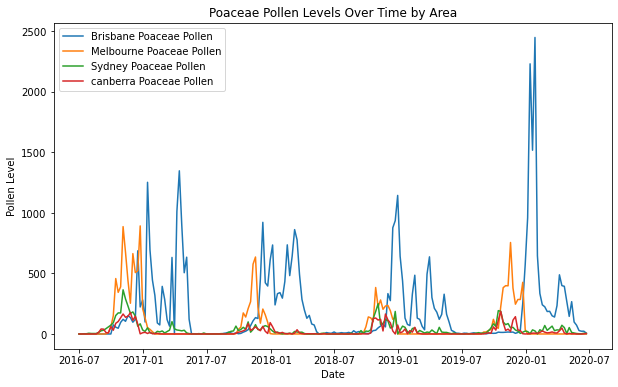

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 将日期列转换为日期格式
pollen['start_date'] = pd.to_datetime(pollen['start_date'])

# 按地区和日期排序
pollen.sort_values(['area', 'start_date'], inplace=True)

# 绘制时间序列图
plt.figure(figsize=(10, 6))
for area in pollen['area'].unique():
    area_data = pollen[pollen['area'] == area]
    plt.plot(area_data['start_date'], area_data['poaceae_pollen'], label=f'{area} Poaceae Pollen')

plt.title('Poaceae Pollen Levels Over Time by Area')
plt.xlabel('Date')
plt.ylabel('Pollen Level')
plt.legend()
plt.show()


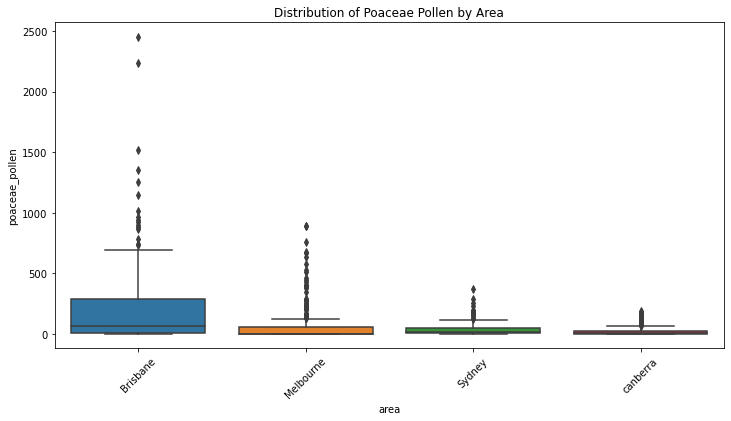

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x='area', y='poaceae_pollen', data=pollen)
plt.xticks(rotation=45)
plt.title('Distribution of Poaceae Pollen by Area')
plt.show()


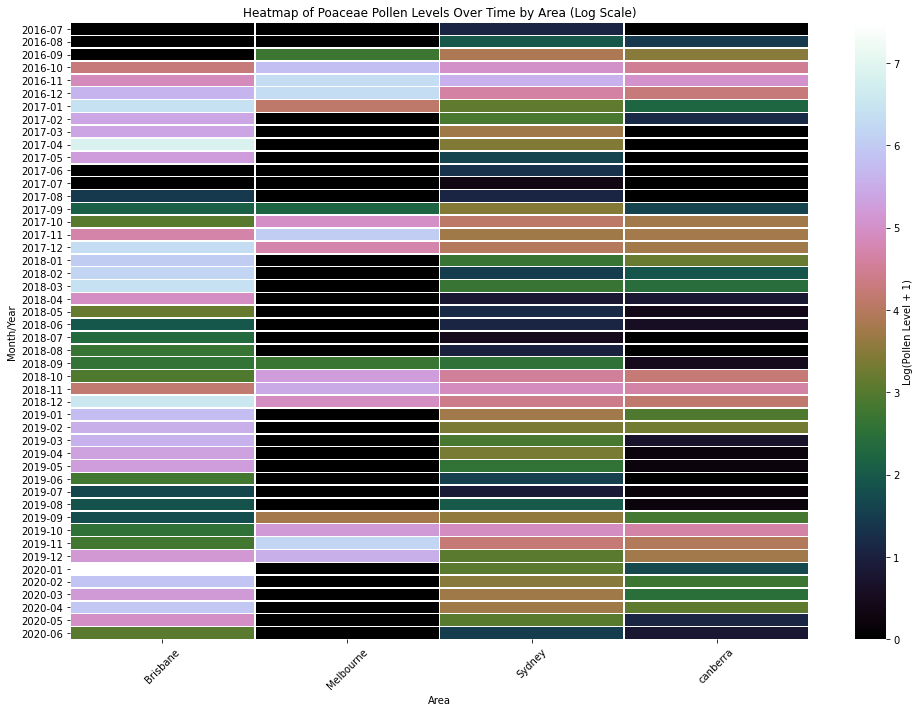

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 假设数据已经正确加载
# pollen['start_date'] = pd.to_datetime(pollen['start_date'])

# 创建适用于热图的数据透视表
heatmap_data = pollen.pivot_table(index=pollen['start_date'].dt.to_period("M"), columns='area', values='poaceae_pollen', aggfunc='mean')

# 设置图形大小
plt.figure(figsize=(14, 10))

# 使用对数尺度和cubehelix色彩映射
sns.heatmap(np.log1p(heatmap_data), cmap='cubehelix', annot=False, cbar_kws={'label': 'Log(Pollen Level + 1)'}, linewidths=.5)

# 设置图表标题和坐标轴标签
plt.title('Heatmap of Poaceae Pollen Levels Over Time by Area (Log Scale)')
plt.xlabel('Area')
plt.ylabel('Month/Year')

# 调整x轴和y轴标签的角度
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# 确保布局整洁
plt.tight_layout()

# 显示图表
plt.show()


